In [ ]:
import os
import pickle
import string
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.merge import add
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Input,Dense,LSTM,Embedding,Dropout
from keras.preprocessing.image import img_to_array,load_img
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
%matplotlib inline

Using TensorFlow backend.


In [ ]:
def extract_features(directory):
  model = VGG16()
  model.layers.pop()
  model = Model(inputs=model.inputs,outputs=model.layers[-1].output)
  print(model.summary())
  features = {}
  i=0
  for name in os.listdir(directory):
    print(i)
    img = load_img(directory+'/'+name,target_size=(224,224))
    img = img_to_array(img)
    img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
    img = preprocess_input(img)
    feature = model.predict(img,verbose=0)
    img_id = name.split('.')[0]
    features[img_id] = feature
    i+=1
  return features

directory ='drive/My Drive/image_captioning/Flicker8k/Flicker8k_Dataset'
features = extract_features(directory)
# pickle.dump(features,open('drive/My Drive/Flicker8k/Flicker_dataset_image_features.pkl','wb'))

In [ ]:
def load_description(filename):
  mappings = {}
  file = open(filename,'r')
  content = file.readlines()
  file.close()
  for lines in content:
    tokens = lines.split()
    if len(lines)<2:
      continue
    image_id,image_desc = tokens[0].split('.')[0],tokens[1:]
    image_desc = ' '.join(image_desc)
    if image_id not in mappings:
      mappings[image_id] = []
    mappings[image_id].append(image_desc)
  return mappings


def clean_description(descriptions):
  table = str.maketrans('','',string.punctuation)
  for k,image_descriptions in descriptions.items():
    for i in range(len(image_descriptions)):
      desc = image_descriptions[i]
      desc = desc.split()
      desc = [x.lower() for x in desc]
      desc = [w.translate(table) for w in desc]
      desc = [x for x in desc if len(x)>1]
      desc = [x for x in desc if x.isalpha()]
      image_descriptions[i] = ' '.join(desc)

def create_corpus(descriptions):
  corpus = set()
  for k in descriptions.keys():
    [corpus.update(x.split()) for x in descriptions[k]]
  return corpus

def save_descriptions(desc,filename):
  lines = []
  for k,v in desc.items():
    for description in v:
      lines.append(k+' '+description)
  data = '\n'.join(lines)
  file = open(filename,'w')
  file.write(data)
  file.close()

# load all descriptions
filename = 'drive/My Drive/image_captioning/Flicker8k/Flickr8k.token.txt'
descriptions = load_description(filename)
print('Descriptions loaded: ',len(descriptions))

# clean the loaded descriptions
clean_description(descriptions)

# check the vocabulary length
vocabulary = create_corpus(descriptions)
print('Vocabulary length: ',len(vocabulary))
save_descriptions(descriptions,'drive/My Drive/image_captioning/descriptions.txt')

print('SAVED !!!')

Descriptions loaded:  8092
Vocabulary length:  8763
SAVED !!!


In [ ]:
def load_set_of_image_ids(filename):
  file = open(filename,'r')
  lines = file.readlines()
  file.close()
  image_ids = set()
  for line in lines:
    if len(line)<1:
      continue
    image_ids.add(line.split('.')[0])
  return image_ids

def load_clean_descriptions(all_desc,train_desc_names):
  file = open(all_desc,'r')
  lines = file.readlines()
  descriptions = {}
  for line in lines:
    tokens = line.split()
    image_id,image_desc = tokens[0].split('.')[0],tokens[1:]
    if image_id in train_desc_names:
      if image_id not in descriptions:
        descriptions[image_id] = []
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      descriptions[image_id].append(desc)
  return descriptions

def load_image_features(filename,dataset):
  all_features = pickle.load(open(filename,'rb'))
  features = {k:all_features[k] for k in dataset}
  return features

# load train image ids
train = 'drive/My Drive/image_captioning/Flicker8k/Flickr_8k.trainImages.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('drive/My Drive/image_captioning/descriptions.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

# load training image features
train_features = load_image_features('drive/My Drive/image_captioning/Flicker_dataset_image_features.pkl',train_image_ids)
print('training features loaded: ',len(train_features))

train_descriptions

Training images found:  6000
training descriptions loaded:  6000
training features loaded:  6000


{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

In [ ]:
def to_list(descriptions):
  all_desc_list = []
  for k,v in descriptions.items():
    for desc in v:
      all_desc_list.append(desc)
  return all_desc_list

def tokenization(descriptions):
  # list of all the descriptions
  all_desc_list = to_list(descriptions)  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(all_desc_list)
  return tokenizer

# create tokenizer
tokenizer = tokenization(train_descriptions)

# word index is the dictionary /mappings of word-->integer
vocab_size = len(tokenizer.word_index)+1
print('Vocab size: ',vocab_size)

def max_length(descriptions):
  all_desc_list = to_list(descriptions)
  return (max(len(x.split()) for x in all_desc_list))


def create_sequences(tokenizer,desc_list,max_len,photo):
  X1,X2,y = [],[],[]
  # X1 will contain photo
  # X2 will contain current sequence
  # y will contain one hot encoded next word

  for desc in desc_list:
    # tokenize descriptions
    seq = tokenizer.texts_to_sequences([desc])[0]
    for i in range(1,len(seq)):
      # out seq is basically the next word in the sentence
      in_seq,out_seq = seq[:i],seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq],maxlen=max_len)[0]
      # one hot encode output sequence
      out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1),np.array(X2),np.array(y)

# maximum length that a description can have OR the biggest description we are having
max_len = max_length(train_descriptions)
print(max_len)

Vocab size:  7579
34


In [ ]:
def data_generator(descriptions,photos,tokenizer,max_len):
  while 1:
    for k,desc_list in descriptions.items():
      photo = photos[k][0]
      in_img,in_seq,out_seq = create_sequences(tokenizer,desc_list,max_len,photo)
      yield[[in_img,in_seq],out_seq]

def define_model(vocab_size, max_length):
	# image features extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
 
	# input sequence model
	inputs2 = Input(shape=(max_length,))
 	# embedding(input_dimension,output_dimension,)
 	# input dim is always the vocabulary size 
	# output dimension tells the size of vector space in which the words will be embedded
	# mask zero is used when the input itself is 0 then to not confuse it with padded zeros it is used as True
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)

	# decoder model OR output word model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)

	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')

	# summarize model
	print(model.summary())
	return model

In [ ]:
model = define_model(vocab_size,max_len)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
  generator = data_generator(train_descriptions,train_features,tokenizer,max_len)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('drive/My Drive/image_captioning/model_'+str(i)+'.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
6000/6000 [==============================] - 1106s 184ms/step - loss: 4.6536
Epoch 1/1
6000/6000 [==============================] - 1102s 184ms/step - loss: 3.8816
Epoch 1/1
6000/6000 [==============================] - 1123s 187ms/step - loss: 3.6358
Epoch 1/1
6000/6000 [==============================] - 1142s 190ms/step - loss: 3.4669
Epoch 1/1
6000/6000 [==============================] - 1145s 191ms/step - loss: 3.3657
Epoch 1/1
6000/6000 [==============================] - 1143s 191ms/step - loss: 3.2963
Epoch 1/1
6000/6000 [==============================] - 1115s 186ms/step - loss: 3.2449
Epoch 1/1
6000/6000 [==============================] - 1105s 184ms/step - loss: 3.2022
Epoch 1/1
6000/6000 [==============================] - 1099s 183ms/step - loss: 3.1715
Epoch 1/1
6000/6000 [==============================] - 1095s 182ms/step - loss: 3.1417
Epoch 1/1
6000/6000 [==============================] - 1110s 185ms/step - loss: 3.1216
Epoch 1/1
6000/6000 [======================

In [ ]:
def int2word(tokenizer,integer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

def predict_desc(model,tokenizer,photo,max_len):
  in_seq = 'startseq'
  for i in range(max_len):
    seq = tokenizer.texts_to_sequences([in_seq])[0]
    seq = pad_sequences([seq],maxlen=max_len)
    y_hat = model.predict([photo,seq],verbose=0)
    y_hat = np.argmax(y_hat)
    word = int2word(tokenizer,y_hat)
    if word==None:
      break
    in_seq = in_seq+' '+word
    if word=='endseq':
      break
  return in_seq

def evaluate_model(model,descriptions,photos,tokenizer,max_len):
  actual,predicted = [],[]
  for key,desc in descriptions.items():
    y_hat = predict_desc(model,tokenizer,photos[key],max_len)
    references = [d.split() for d in desc]
    actual.append(references)
    predicted.append(y_hat.split())
  print('BLEU-1: %f' %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
  print('BLEU-2: %f' %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
  print('BLEU-3: %f' %corpus_bleu(actual,predicted,weights=(0.33,0.33,0.33,0)))
  print('BLEU-4: %f' %corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

In [ ]:

####################  load training data (6k)  ##########################
train = 'drive/My Drive/image_captioning/Flicker8k/Flickr_8k.trainImages.txt'
train_image_ids = load_set_of_image_ids(train)
print('Training images found: ',len(train_image_ids))

# load training descriptions
train_descriptions = load_clean_descriptions('drive/My Drive/image_captioning/descriptions.txt',train_image_ids)
print('training descriptions loaded: ',len(train_descriptions))

tokenizer = tokenization(train_descriptions)
max_len = max_length(train_descriptions)

####################  load test data  ##########################
test = 'drive/My Drive/image_captioning/Flicker8k/Flickr_8k.testImages.txt'
test_image_ids = load_set_of_image_ids(test)
print('Test images found: ',len(test_image_ids))

# load test descriptions
test_descriptions = load_clean_descriptions('drive/My Drive/image_captioning/descriptions.txt',test_image_ids)
print('test descriptions loaded: ',len(test_descriptions))

# load test image features
test_features = load_image_features('drive/My Drive/image_captioning/Flicker_dataset_image_features.pkl',test_image_ids)
print('training features loaded: ',len(test_features))
#################################################################
filename = 'drive/My Drive/image_captioning/model_18.h5'
model = load_model(filename)
evaluate_model(model,test_descriptions,test_features,tokenizer,max_len)

Training images found:  6000
training descriptions loaded:  6000
Test images found:  1000
test descriptions loaded:  1000
training features loaded:  1000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


BLEU-1: 0.517051
BLEU-2: 0.275973
BLEU-3: 0.158415
BLEU-4: 0.086634


In [ ]:
# live testing

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



two young boys are playing soccer on the grass


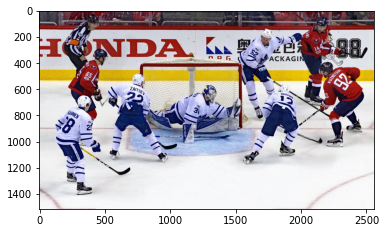

In [ ]:
img_to_test = 'drive/My Drive/image_captioning/983801190.jpg'
img = plt.imread(img_to_test)
plt.imshow(img)

def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('drive/My Drive/image_captioning/model_18.h5')
# load and prepare the photograph
photo = extract_features(img_to_test)
# generate description
description = predict_desc(model, tokenizer, photo, max_length)

description = ' '.join(description.split()[1:-1])
print()
print(description)